## OLS, LASSO and Ridge regression solution

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
random.seed(106) # fixing the random seed

#### Problem definition

In [2]:
polyPower = [0,1,2,3,4,5] # powers of polynomial basis
N = len(polyPower) # number of basis
def basisFun(Xth,ith): # polynomial basis
    return Xth**polyPower[ith]
trueKnown =1 # 0 = dont plot true, 1= plot true 
Wtrue=[0]*N # true parameter definition, for plotting
Wtrue[0]=1
Wtrue[2]=1 
RHOtrue = 100 # true value of error precision

#### Load observations and generate design matrix 

In [3]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,N))
for i in range(0,M):
    for j in range(0,N):
        Phi[i,j] = basisFun(Xobs[i],j)

#### Ordinary least square (OLS)

In [4]:
PRols = np.matmul(np.transpose(Phi),Phi)
Wols = np.matmul(la.inv(PRols),np.matmul(np.transpose(Phi),Yobs))
RHOols = (M-N)/np.power(la.norm(Yobs - np.matmul(Phi,Wols),2),2)

#### Ridge regression

In [5]:
# optimal lambda is obtained from minimum cross-validation error (see below)
lamdaRR = 0.001 # Regularization coefficient
Mtemp = lamdaRR*np.identity(N)
Mtemp[0,0] = 0 # mean parameter w0 not included in regularization
PRmod = PRols+Mtemp
PRridge = (PRols+Mtemp)*la.inv(PRols)*(PRols+lamdaRR*np.identity(N)) # precision matrix for Wridge, if needed
Wridge = np.matmul(la.inv(PRols+Mtemp),np.matmul(np.transpose(Phi),Yobs))
RHOridge = (M-N)/np.power(la.norm(Yobs - np.matmul(Phi,Wridge),2),2)

#### LASSO

In [6]:
# optimal lambda is obtained from minimum cross-validation error (see below)
lamdaLR = 0.001  # lambda value for LASSO regression
Win = [1e-6]*N # Initial value for optimization
Win[0] = 1
Win[2] = 1
def lassoObj(W):
    return np.power(la.norm(Yobs-np.matmul(Phi,W),2),2) + lamdaLR*np.sum(np.absolute(W[1:]))
lassoSoln = minimize(lassoObj, Win, method='BFGS',options={'gtol': 1e-10, 'disp': False})
Wlasso = lassoSoln.x
Nnew = sum(abs(i) < 1e-02 for i in Wlasso)
RHOlasso = (M-N+Nnew)/np.power(la.norm(Yobs - np.matmul(Phi,Wlasso),2),2)

In [7]:
print('  i           Estimates for w                  | Precision estimate for w  ')
print('  i    true        ols      lasso      ridge   |    ols       ridge  ')
for i in range(0,N):
    print("{0:3d}{1:11.3e}{2:11.3e}{3:11.3e}{4:10.3e} | {5:10.2e}{6:10.2e}".format(\
        int(i), Wtrue[i], Wols[i], Wlasso[i], Wridge[i], PRols[i,i], PRridge[i,i]))
print("Rho{0:11.3e}{1:11.3e}{2:11.3e}{3:10.3e} |".format(RHOtrue, RHOols,RHOlasso,RHOridge))
print("\nCond(Phi^TPhi):          {0:10.2e}{1:5d}/{2:2d}".format(la.cond(PRols), la.matrix_rank(PRols),N))
print("Cond(Phi^TPhi+lambda*I): {0:10.2e}{1:5d}/{2:2d}".format(la.cond(PRmod), la.matrix_rank(PRmod),N))

  i           Estimates for w                  | Precision estimate for w  
  i    true        ols      lasso      ridge   |    ols       ridge  
  0  1.000e+00  1.041e+00  9.485e-01 9.468e-01 |   2.50e+01  4.83e+02
  1  0.000e+00 -3.350e+00  5.882e-01 6.165e-01 |   8.51e+00  2.63e+04
  2  1.000e+00  2.978e+01 -8.063e-02-1.751e-01 |   5.31e+00  4.37e+05
  3  0.000e+00 -8.173e+01 -1.056e-08 6.691e-02 |   3.95e+00  1.62e+06
  4  0.000e+00  9.326e+01  7.353e-01 8.053e-01 |   3.19e+00  1.31e+06
  5  0.000e+00 -3.698e+01 -8.308e-02-1.533e-01 |   2.72e+00  1.50e+05
Rho  1.000e+02  1.084e+02  8.252e+01 7.846e+01 |

Cond(Phi^TPhi):            1.10e+07    6/ 6
Cond(Phi^TPhi+lambda*I):   4.14e+04    6/ 6


#### Plot model predictions vs observations

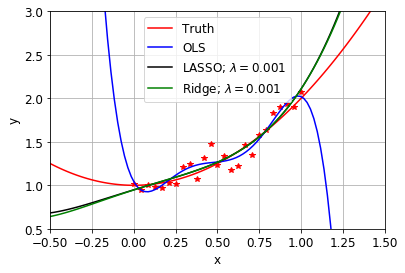

In [8]:
mpl.rcParams.update({'font.size':12})
Xextra = 0.501 # width for extrapolation
Yrnge = [0.5,3] 
Mnew = 100
Xrnge = [min(Xobs)-Xextra,max(Xobs)+Xextra]
Xnew = np.linspace(Xrnge[0],Xrnge[1],Mnew)
PhiNew = np.zeros((Mnew,N))
for i in range(0,Mnew):
    for j in range(0,N):
        PhiNew[i,j] = basisFun(Xnew[i],j)
Yols = np.matmul(PhiNew,Wols)
Yridge = np.matmul(PhiNew,Wridge)
Ylasso = np.matmul(PhiNew,Wlasso)
fig = plt.figure(3)
plt.plot(Xobs,Yobs,'r*')
if trueKnown ==1:
    Ytrue = np.matmul(PhiNew,np.transpose(Wtrue))
    plt.plot(Xnew,Ytrue,'r-',label='Truth')
plt.plot(Xnew,Yols,'b-',label='OLS')
plt.plot(Xnew,Ylasso,'k-',label=r'LASSO; $\lambda=$'+str(lamdaLR)+'')
plt.plot(Xnew,Yridge,'g-',label=r'Ridge; $\lambda=$'+str(lamdaRR)+'')
plt.grid(True)
plt.ylabel('y')
plt.xlabel('x')
plt.ylim([0.8*np.min(Ytrue),1.2*np.max(Ytrue)])
plt.ylim(Yrnge)
plt.xlim([Xrnge[0],Xrnge[1]])
plt.legend(loc='best', numpoints = 1)
plt.savefig('figs/1_RLS_pred.eps',bbox_inches='tight')

#### K-Fold cross-validation

In [9]:
k = 5 # number of groups data is grouped
lamdaRange = [-3,1] # 10^ range of lambda variation
Niter = 30 # lambda grid length
Mbin = int(M/k) # equaly sized groups 
Ncv = 10 # number of realizations of CV error

In [10]:
lamdaIter = np.power(10,np.linspace(lamdaRange[0],lamdaRange[1],Niter))
CVerLasso = [0]*Niter
CVerRidge = [0]*Niter
CVerOls = [0]*Niter
for ii in range(0,Ncv):
    CVerr1 = [0]*k
    CVerr2 = [0]*k
    CVerr3 = [0]*k
    IndList = list(range(0,M))
    Wtemp=[1e-10]*N
    random.shuffle(IndList)
    for i in range(0,Niter):
        lamdai = lamdaIter[i]
        for j in range(0,k):
            trainList=[]
            testList = []
            trainList = IndList[0:j*Mbin]
            trainList.extend(IndList[(j+1)*Mbin:M])
            testList = IndList[j*Mbin:(j+1)*Mbin]
            PhiTrain = Phi[trainList,:]
            Ytrain = Yobs[trainList]
            PhiTest  = Phi[testList,:]
            Ytest = Yobs[testList]
            PRolsT = np.matmul(np.transpose(PhiTrain),PhiTrain)
            Mtemp = lamdai*np.identity(N)
            Mtemp[0,0] = 0
            Wols = np.matmul(la.inv(PRolsT),np.matmul(np.transpose(PhiTrain),Ytrain))
            Wridge = np.matmul(la.inv(PRolsT+Mtemp),np.matmul(np.transpose(PhiTrain),Ytrain))
            def lassoObj(W):
                return np.power(la.norm(Ytrain-np.matmul(PhiTrain,W),2),2) + lamdai*np.sum(np.absolute(W[1:]))
            lassoSoln = minimize(lassoObj, Wtemp, method='Nelder-Mead',options={'xatol': 1e-12, 'fatol': 1e-12, 'disp': False})
            CVerr1[j] = np.power(la.norm((Ytest - np.matmul(PhiTest,Wridge)),2),2)
            CVerr2[j] = np.power(la.norm((Ytest - np.matmul(PhiTest,lassoSoln.x)),2),2)
            CVerr3[j] = np.power(la.norm((Ytest - np.matmul(PhiTest,Wols)),2),2)
            Wtemp = lassoSoln.x
        CVerLasso[i] = CVerLasso[i] + np.mean(CVerr2)
        CVerRidge[i] = CVerRidge[i] + np.mean(CVerr1)
        CVerOls[i] = CVerOls[i] + np.mean(CVerr3)
CVols = [x/Ncv for x in CVerOls]
CVridge = [x/Ncv for x in CVerLasso]
CVlasso = [x/Ncv for x in CVerRidge]

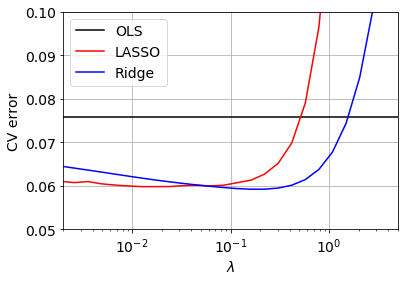

In [11]:
mpl.rcParams.update({'font.size':14})
fig = plt.figure(1)
plt.semilogx(lamdaIter,CVols,'k-',label='OLS')
plt.semilogx(lamdaIter,CVridge,'r-',label='LASSO')
plt.semilogx(lamdaIter,CVlasso,'b-',label='Ridge')
plt.grid(True)
plt.ylim([0.05,0.1])
#plt.ylim([0.01,0.02])
plt.xlim([0.002,5])
plt.xlabel(r'$\lambda$')
plt.ylabel('CV error')
plt.legend(loc='best', numpoints = 1)
plt.savefig('figs/1_RLS_KfoldCV_'+str(k)+'.eps',bbox_inches='tight') 